In [34]:
cd E:\\dataanalysisgroup\\bankdata

E:\dataanalysisgroup\bankdata


In [35]:
import pandas as pd
import seaborn as sns
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
%matplotlib inline

from sklearn.decomposition import PCA

## 加载数据集

In [36]:
train = pd.read_csv('train_2.csv')
test = pd.read_csv('test_2.csv')
# train = pd.read_csv('train_4.csv') # 原始数据特征筛选后
# test = pd.read_csv('test_4.csv') # 原始数据集特征筛选后

In [37]:
train.columns

Index([u'CUST_ID', u'OPEN_ORG_NUM', u'IDF_TYP_CD', u'GENDER', u'bad_good',
       u'CUST_INTERNATIONAL_GOLD_FLAG', u'CUST_INTERNATIONAL_COMMON_FLAG',
       u'CUST_INTERNATIONAL_SIL_FLAG', u'CUST_INTERNATIONAL_DIAMOND_FLAG',
       u'CUST_GOLD_COMMON_FLAG', u'CUST_STAD_PLATINUM_FLAG',
       u'CUST_LUXURY_PLATINUM_FLAG', u'CUST_PLATINUM_FINANCIAL_FLAG',
       u'CUST_DIAMOND_FLAG', u'CUST_INFINIT_FLAG', u'CUST_BUSINESS_FLAG',
       u'CUST_ASSET_AMT', u'CUST_DEBT_AMT', u'L3_CUST_ASSET_AVG_AMT',
       u'L6_CUST_ASSET_AVG_AMT', u'L3_CUST_DEBT_AVG_AMT',
       u'L6_CUST_DEBT_AVG_AMT', u'DEP_SA_OPEN_TENURE_DAYS',
       u'DEP_SA_LAST_TENURE_DAYS', u'DEP_SA_AVG_TENURE_DAYS',
       u'DEP_SA_SUMACCOUNT_CNT', u'L3_DEP_SA_AVG_ACCOUNT_CNT',
       u'L6_DEP_SA_AVG_ACCOUNT_CNT', u'DEP_TD_FLAG', u'LOAN_FLAG',
       u'FUND_FLAG', u'C_FUND_FLAG', u'D_FUND_FLAG', u'S_FUND_FLAG',
       u'BOND_FLAG', u'CER_BOND_FLAG', u'BK_BOND_FLAG', u'LG_TXN_AMT',
       u'LG_TXN_CNT', u'L3_LG_TXN_AVG_AMT', u'L3_L

In [38]:
#descriptive statistics summary
train['bad_good'].describe()

count    9506.000000
mean        0.513781
std         0.499836
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: bad_good, dtype: float64

## 相关性分析筛选关键变量

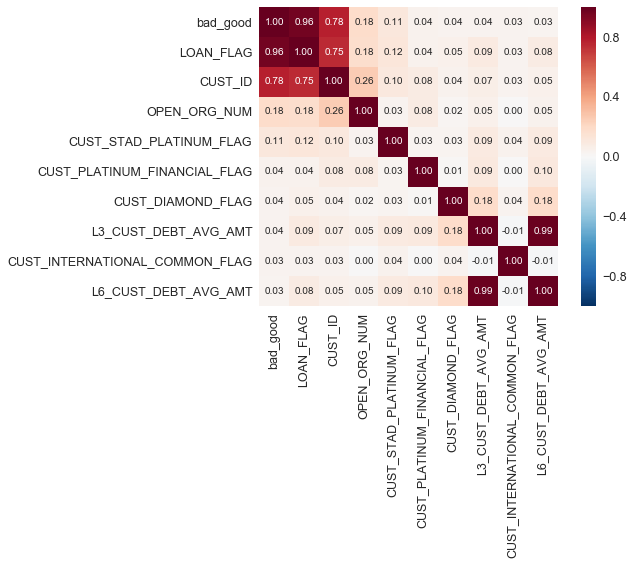

In [39]:
k = 10 #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k,'bad_good')['bad_good'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)
plt.show()

    由相关性分析发现LOAN_FLAG（个货标识）、DEP_SA_OPEN_TENURE_DAYS（活期存款最早开户日期距今月份）、DEP_SA_LAST_TENURE_DAYS（活期存款最近开户距今月份）、DEP_SA_AVG_TENURE_DAYS（活期存款平均开户时长）以及其他几个因素可能是影响被观测变量bad_good（客户流失指标）的关键因素。但其他关键影响因素很有可能被遗漏，因为仅通过相关性分析是不具有说服力的。接下来还需要通过其他统计方法提取出关键特征。

In [40]:
train.head()

,CUST_ID,OPEN_ORG_NUM,IDF_TYP_CD,GENDER,bad_good,CUST_INTERNATIONAL_GOLD_FLAG,CUST_INTERNATIONAL_COMMON_FLAG,CUST_INTERNATIONAL_SIL_FLAG,CUST_INTERNATIONAL_DIAMOND_FLAG,CUST_GOLD_COMMON_FLAG,...,S_FUND_FLAG,BOND_FLAG,CER_BOND_FLAG,BK_BOND_FLAG,LG_TXN_AMT,LG_TXN_CNT,L3_LG_TXN_AVG_AMT,L3_LG_TXN_AVG_CNT,L6_LG_TXN_AVG_AMT,L6_LG_TXN_AVG_CNT
0,1000000024,1101,ZR01,2,0,0,0,0,1,0,...,0,0,0,0,903794.10,7,3.771310e+06,14.333333,2.305946e+06,8.666667
1,1000000515,602,ZR01,1,0,0,0,0,1,0,...,0,0,0,0,311426.85,1,2.071423e+05,0.666667,2.206195e+05,1.166667
2,1000003231,602,ZR01,2,1,1,0,0,0,0,...,0,0,0,0,1109744.67,12,1.597219e+06,13.333333,1.391494e+06,9.500000
3,1000003736,602,ZR01,1,0,0,0,0,0,0,...,0,0,0,0,0.00,0,0.000000e+00,0.000000,0.000000e+00,0.000000
4,1000003852,602,ZR01,1,0,0,0,0,0,1,...,0,0,0,0,0.00,0,0.000000e+00,0.000000,1.666667e+04,0.166667


## 特征工程

In [41]:
Y_train = train['bad_good'] # sava the labels to a Pandas series target

train_1 = train.drop('bad_good',axis=1) # drop the label feature
IDF_TYP_CD_train = train_1['IDF_TYP_CD'] # sava the labels to a Pandas series target
train = train_1.drop('IDF_TYP_CD',axis=1) # drop the label feature
CUST_ID_train = train['CUST_ID']
train = train.drop('CUST_ID',axis=1)

Y_test = test['bad_good'] # sava the labels to a Pandas series target

test_1 = test.drop('bad_good',axis=1) # drop the label feature
IDF_TYP_CD_test = test_1['IDF_TYP_CD'] # sava the labels to a Pandas series target
test = test_1.drop('IDF_TYP_CD',axis=1) # drop the label feature
CUST_ID_test = test['CUST_ID']
test = test.drop('CUST_ID',axis=1)

In [42]:
print(train.shape)

(9506, 40)


In [43]:
print(test.shape)

(3999, 40)


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9506 entries, 0 to 9505
Data columns (total 40 columns):
OPEN_ORG_NUM                       9506 non-null int64
GENDER                             9506 non-null int64
CUST_INTERNATIONAL_GOLD_FLAG       9506 non-null int64
CUST_INTERNATIONAL_COMMON_FLAG     9506 non-null int64
CUST_INTERNATIONAL_SIL_FLAG        9506 non-null int64
CUST_INTERNATIONAL_DIAMOND_FLAG    9506 non-null int64
CUST_GOLD_COMMON_FLAG              9506 non-null int64
CUST_STAD_PLATINUM_FLAG            9506 non-null int64
CUST_LUXURY_PLATINUM_FLAG          9506 non-null int64
CUST_PLATINUM_FINANCIAL_FLAG       9506 non-null int64
CUST_DIAMOND_FLAG                  9506 non-null int64
CUST_INFINIT_FLAG                  9506 non-null int64
CUST_BUSINESS_FLAG                 9506 non-null int64
CUST_ASSET_AMT                     9506 non-null float64
CUST_DEBT_AMT                      9506 non-null float64
L3_CUST_ASSET_AVG_AMT              9506 non-null float64
L6_CUST

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 40 columns):
OPEN_ORG_NUM                       3999 non-null int64
GENDER                             3999 non-null int64
CUST_INTERNATIONAL_GOLD_FLAG       3999 non-null int64
CUST_INTERNATIONAL_COMMON_FLAG     3999 non-null int64
CUST_INTERNATIONAL_SIL_FLAG        3999 non-null int64
CUST_INTERNATIONAL_DIAMOND_FLAG    3999 non-null int64
CUST_GOLD_COMMON_FLAG              3999 non-null int64
CUST_STAD_PLATINUM_FLAG            3999 non-null int64
CUST_LUXURY_PLATINUM_FLAG          3999 non-null int64
CUST_PLATINUM_FINANCIAL_FLAG       3999 non-null int64
CUST_DIAMOND_FLAG                  3999 non-null int64
CUST_INFINIT_FLAG                  3999 non-null int64
CUST_BUSINESS_FLAG                 3999 non-null int64
CUST_ASSET_AMT                     3999 non-null float64
CUST_DEBT_AMT                      3999 non-null float64
L3_CUST_ASSET_AVG_AMT              3999 non-null float64
L6_CUST

### 训练集与测试集

In [46]:
X_train = train.values
X_test = test.values
y_train = Y_train.values
y_test = Y_test.values

In [47]:
# 流失客户数量
sum(y_train)

4884

In [48]:
# 训练集客户总数
len(y_train)

9506

### PCA降维

In [49]:
# 数据标准化
from sklearn.preprocessing import StandardScaler
# X_train = train.sample(200).values #随机选取少量部分样本
X_std = StandardScaler().fit_transform(X_train)

# Calculating Eigenvectors and eigenvalues of Cov matrixs
mean_vec = np.mean(X_std,axis=0)
cov_mat = np.cov(X_std.T)
eig_vals,eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue,eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue,eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0],reverse = True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals,reverse = True)]#individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [50]:
trace1 = go.Scatter(
    x=list(range(624)),
    y=cum_var_exp,
    mode='lines+markers',
    name="'Cumulative Explained Variance'",
    hoverinfo=cum_var_exp,
    line=dict(
        shape='spline',
        color='goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(624)),
    y=cum_var_exp,
    mode='lines+markers',
    name="'Individual Explained Variance'",
    hoverinfo=var_exp,
    line=dict(
        shape='linear',
        color='black'
    )
)
fig = tls.make_subplots(insets=[{'cell':(1,1),'l':0.7,'b':0.5}],print_grid=True)
fig.append_trace(trace1,1,1)
fig.append_trace(trace2,1,1)
fig.layout.title = 'Explained Variance plots - Full and Zoomed-in'
fig.layout.xaxis = dict(range=[0,80],title = 'Feature columns')
fig.layout.yaxis = dict(range=[0,60],title = 'Explained Variance')
fig['data'] += [go.Scatter(x=list(range(784)),y=cum_var_exp,xaxis='x2',yaxis='y2',name = 'Cumulative Explained Variance')]
fig['data'] += [go.Scatter(x=list(range(784)),y=var_exp,xaxis='x2',yaxis='y2',name='Individual Explained Variance')]

# fig['data'] = data
# fig['layout'] = layout
# fig['data'] += data2
# fig['layout'] += layout2
py.iplot(fig,filename='inset example')

This is the format of your plot grid:
[ (1,1) x1,y1 ]

With insets:
[ x2,y2 ] over [ (1,1) x1,y1 ]



## 决策树算法

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=50, min_samples_leaf=50)
clf = clf.fit(X_train,y_train) # 要非标准化的数据！

y_pred=clf.predict(X_test) #预测

#混淆矩阵模块
from sklearn.metrics import confusion_matrix
print (confusion_matrix(y_test,y_pred))#验证集上的混淆矩阵

[[1986   13]
 [  31 1969]]


In [52]:
# y_pred=clf.predict(X_train)
# print (confusion_matrix(y_train,y_pred))#训练集上的混淆矩阵

In [53]:
#准确率及召回率等Report模块
from sklearn.metrics import classification_report
print (classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1999
          1       0.99      0.98      0.99      2000

avg / total       0.99      0.99      0.99      3999



In [54]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, slpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                    alpha=1.0, linewidth=1, marker='o',
                    s=55, label='test set')

In [55]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test,y_test,classifier=clf,test_idx=range(105,150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

TypeError: plot_decision_regions() got an unexpected keyword argument 'classifier'

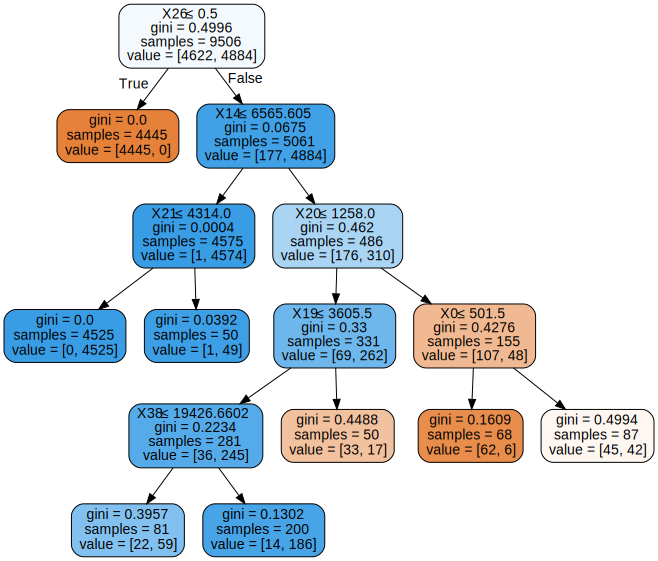

In [56]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                            filled=True, rounded=True,
                            special_characters=True)
graph = graphviz.Source(dot_data)
graph